<h2 style="margin-bottom:0px; line-height:1.5"><center>Chapter 1: <u>Restricted Hartree Fock (RHF)</u> for Simple Atom (He and Be) using  <u>Slater Type Orbital (STO)</u>
    with <u> Double Zeta Basis</u> in Python</center></h2>
<center>Integral calculated by sympy</center>

<p style="text-align: center; margin-top: 10px; margin-bottom: 0px;">
    <a target="_blank" href="http://simuc.chem.ufl.edu/">SIMUC PROJECT</a>
</p>

<p style="text-align: center; margin-top: 10px; margin-bottom: 0px;">
    By <a target="_blank" href="https://github.com/yueyericardo">Jinze (Richard) Xue</a>&nbsp;&nbsp;&nbsp;/&nbsp;
    <a target="_blank" href="https://github.com/yueyericardo/simuc/tree/master/notebooks/pchem/hartree-fock/sto">Source code</a>
</p>


1. It will be better to understand if you have read <u>Levine, Quantum Chemistry, 7th Edition, chapter 11 and 14</u>.  
There is an example calculation of Helium atom at page 412-414.

1. For well-organized and documented python file, please find in github: https://github.com/yueyericardo/simuc/tree/master/notebooks/pchem/hartree-fock/sto

1. This notebook is self-contained.  
However, if you wanna try in other place, you should put `hf.py` file in the same directory where you wanna import it. 

### Chapters
- Chapter 1: Restricted Hartree Fock (RHF) for Simple Atom (He and Be) using Slater Type Orbital (STO) with Double Zeta Basis in Python
- Chapter 2: Slater Type Orbital (STO) VS Gaussian Type Orbital (GTO) <font color=red>【WIP】</font>   
  Interactive tool <font color=red>【WIP】</font>     
- Chapter 3: Restricted Hartree Fock (RHF) for Simple diatomic molecule (H2 and HeH+) using Gaussian Type Orbital (GTO) with STO-3G Basis in Python  <font color=red>【Code is on [github](https://github.com/yueyericardo/simuc/tree/master/notebooks/pchem/hartree-fock/gto)】【Document WIP】</font>   
- Chapter 4: Restricted Hartree Fock (RHF) for Polyatomic Molecule using Simple and Powerful Package: PSI4<font color=red>【WIP】</font>   

### Overview
1. [Introduction](#1.-Introduction)
1. [Born–Oppenheimer approximation](#2.-Born–Oppenheimer-approximation)
2. [Hartree fock approximation](#3.-Hartree-fock-approximation)
3. [Why build matrix and how to solve secular equation?](#4.-Why-build-matrix-and-how-to-solve-secular-equation?)
4. [How to build matrix](#5.-How-to-build-matrix)
5. [Secular Equation](#6.-Secular-Equation)
6. [Total Energy](#7.-Total-Energy)
7. [Utils](#8.-Utils)
8. [Run Hartree Fock](#9.-Run-Hartree-Fock)
9. [Test](#10.-Test)
10. [Excise - Plot the charge density of orbitals](#11.-Excise---Plot-the-charge-density-of-orbitals)
10. [Limitations](#12.-Limitations)
11. [Reference](#13.-Reference)


---

### 1. Introduction
In this notebook, we will use Helium Atom as an example to explain Restricted Hartree Fock (RHF) method.  
(Restricted means only for closed shell molecule, orbitals are either doubly occupied or empty)

Helium has two electrons on 1s orbital.  

One-electron wavefunction of 1s orbital could be written as $^*$
$$\chi_{1 \mathrm{s}}^{\mathrm{STO}}=\left(\frac{\zeta^{3}}{\pi}\right)^{1 / 2} \exp (-\zeta r)$$
<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold;"> [*] </span> 
    For simplicity, there is no angular part since it's s orbital.
    <br>
    $\zeta$ is a constant related to the effective charge of the nucleus, the nuclear charge being partly shielded by electrons.
<p>
With double zeta, we are saying we will buil two $\chi_{1 \mathrm{s}}^{\mathrm{STO}}$ function. And the final 1s orbital of Helium will be a linear combination of these two STO.  $$\phi_1 = c_{11} \chi_1 + c_{21} \chi_2  \quad \text{(occupied orbital)}\;\; \tag {Eq1}$$ $$\phi_2 = c_{12} \chi_1 + c_{22} \chi_2 \quad \text{(unoccupied orbital)}$$

<p style="color:red"><b>The goal of hartree fock is using Self-Consistent Field method (SCF) to optimize coefficients to get close to the real wavefunction.</b></p>

For Helium, from reference [[1]](https://www.sciencedirect.com/science/article/pii/S0092640X74800161), two double zeta are 1.45363, 2.91093.   
We could build these two STO with each zeta using sympy like below.

In [1]:
import hf
import sympy as sp
import numpy as np
import scipy.linalg
from sympy import oo
from sympy import diff
import time
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Math
sp.init_printing()
%matplotlib inline

In [2]:
r, r1, r2, zeta = sp.symbols("r, r1, r2, zeta")
n = sp.Symbol('n', integer=True)

In [3]:
def STO(zeta, n, r=r):
    """
    Define a Slater Type Orbital function using sympy.

    INPUT:
    zeta: zeta for the STO.
    n: principle quantum number for the STO.
    """
    f = r ** (n - 1) * sp.exp(-zeta * r)
    # normalization
    N = sp.sqrt(1 / sp.integrate(4 * sp.pi * f * f * r * r, (r, 0, +oo)))
    return N * f

In [4]:
f1s_1 = hf.STO(zeta=1.45363, n=1)
f1s_2 = hf.STO(zeta=2.91093, n=1)

display(Math('$\chi_1 :'))
display(f1s_1)
display(Math('$\chi_2 :'))
display(f1s_2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<span style="font-weight: bold; color: red"> Note: </span> More detail about this will be covered at part 2, but I want to point out the main idea at beginning. So it could remind you what's our final goal, when you feel distracted.

By using Roothan equations below , which could be solved self-consistently for the orbital coefficient matrix **C** and orbital energy eigenvalues $\epsilon_i$ by iterations, we could finally 
1. get close to the real wavefunction (using improved Coefficients for Eq1).
2. get close to correct Molecular orbital energies (using $\epsilon_i$), to get the real total energy

$${\mathbf  {F}}{\mathbf  {C}}={\mathbf  {S}}{\mathbf  {C}}{\mathbf  {\epsilon }}$$
<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold;"> Note: </span> 
    F (Fock matrix), S (Overlap matrix) are inputs.<br>
    S matrix is fixed, F matrix is changing every iteration because of the improved C.<br>
    C (Coefficient matrix) and $\epsilon_i$ (eigenvalues) are results.
    <br>
<p>

---

### 2. Born–Oppenheimer approximation
Using Born–Oppenheimer approximation, molecular Hamiltonian could be expressed as 

$${\displaystyle H=H_{\text{e}}+T_{\text{n}}}$$
<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold;"> Note: </span> 
    e (electron), n (nuclear)
    <br>
<p>
Where

$${\displaystyle H_{\text{e}}=-\sum _{i}{{\frac {1}{2}}\nabla _{i}^{2}}-\sum _{i,\alpha}{\frac {Z_{\alpha}}{r_{i\alpha}}}+\sum _{i>j}{\frac {1}{r_{ij}}}+\sum _{\beta>\alpha}{\frac {Z_{\alpha}Z_{\beta}}{R_{\alpha \beta}}}\quad {\text{and}}\quad T_{\text{n}}=-\sum _{\alpha}{{\frac {1}{2M_{\alpha}}}\nabla _{\alpha}^{2}}}$$
<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold;"> Note: </span> 
    i, j (electron), $\alpha$, $\beta$ (nuclear)
    <br>
<p>

$H_e$:   
1. sum of kinetic-energy operators for each electron
2. sum of nuclear–electronic Coulombic attraction terms
3. sum of electron-electron repulsion energy
4. sum of nuclear-nuclear repulsion energy ($V_{NN}$)

$T_n$: 
1. sum of kinetic-energy operators for each nuclear

Classically, during the time of a cycle of electronic motion, the change in nuclear configuration is negligible. Thus, considering the nuclei as fixed, we omit the nuclear kinetic-energy terms $T_n$. So commonly when we say hartree fock energy, we are only talking about $H_e$ term.

$${\displaystyle H_{\text{e}}=-\sum _{i}{{\frac {1}{2}}\nabla _{i}^{2}}-\sum _{i,\alpha}{\frac {Z_{\alpha}}{r_{i\alpha}}}+\sum_{i} \sum_{j>i}{\frac {1}{r_{ij}}} + V_{NN}}$$

The first 3 terms together is purely electronic Hamiltonian. 

---

### 3. Hartree fock approximation

Because of the inter-electronic repulsion term $\frac{1}{r_{i j}}$, the Schrödinger equation for a molecule wavefunction is not separable. So the true wave function cannot be written as the product of n one-electron functions.  

The essence of hartree-fock approximation is to treat electron-electron repulsion in an average way, so this complicated many-electron problem could be solved as one-electron problem. 

Then the molecular wavefunction could be written as a product of all one-electron wavefunctions. 
The functions chosen to represent each electron is based on the hydrogen-like atomic wavefunction. (<span style="font-weight: bold; color: red"> Note: </span>This is the reason why we use Slater type Orbital (STO), because it's transformed from exact wavefunction for an electron around a hydrogen atom)

$$
\Psi({r_1 r_2})=\phi_{1}\left(\boldsymbol{r}_{1}\right) \phi_{2}\left(\boldsymbol{r}_{2}\right)
$$

However this product does not satisfy antisymmetric requirements (which means if you swap electrons the sign of the wavefunction should invert). This problem can be overcome by taking a linear combination of both products:
$$
\begin{aligned} \Psi\left(\mathbf{r}_{1}, \mathbf{r}_{2}\right) &=\frac{1}{\sqrt{2}}\left\{\phi_{1}\left(\mathbf{r}_{1}\right) \phi_{2}\left(\mathbf{r}_{2}\right)-\phi_{1}\left(\mathbf{r}_{2}\right) \phi_{2}\left(\mathbf{r}_{1}\right)\right\} \\ &=\frac{1}{\sqrt{2}}\left|\begin{array}{ll}{\phi_{1}\left(\mathbf{r}_{1}\right)} & {\phi_{2}\left(\mathbf{r}_{1}\right)} \\ {\phi_{1}\left(\mathbf{r}_{2}\right)} & {\phi_{2}\left(\mathbf{r}_{2}\right)}\end{array}\right| \end{aligned}
$$

In this way, the Schrödinger equation would then be separated into n one-electron hydrogenlike equations.

Suppose there is an operator called Fock operator $\hat F$, the eigenvalue corresponding to $\hat F$ on a one-electron wavefunction is the energy related to this electron.

Each electron energy $\varepsilon_{i}$ will include 
1. kinetic-energy for this electron
2. sum of coulombic attraction between this electron and all nuclears
3. the potential of this electron interacting with an averaged distribution of other electrons, (which is calculated by treating all of the other electrons within the molecule as a smooth distribution of negative charge, and this is the major simplification inherent in the Hartree–Fock method).   
(What does this means? explained at below )

<span style="font-weight: bold; color:red"> Note: </span>  If we take$\sum_{i}^{n} {\varepsilon_{i}}$, we will count each interelectronic repulsion twice, which needs to be subtracted when calculating total energy of molecule.  

What's the meaing of the potential of this electron interacting with an averaged distribution of other electrons?
suppose we want to find the electron-electron repulsion potential ($\text{Vee}$) of electron 1 with electron 2.


$$\text{Vee}_{1 2}=\left\langle\phi (1)^*|\frac{1}{r_{1 2}} | \phi (1)\right\rangle$$
This is not solvable, because we don't know the location of electron (2).

And hartree fock simplify this to:  
(recall that $\left|\phi(2)\right|^{2}$ is the probability density of electron (2)

$$\text{Vee}_{1 2}=\left\langle\phi (1)^*|\;\;\; \int \frac{\left|\phi(2)\right|^{2}}{r_{12}} d v_{2} \;\;\; | \phi (1)\right\rangle \tag{Eq2}$$

By using the probability density of electron (2) $\left|\phi(2)\right|^{2}$, 

$$\text{infinitesimal charge density} * \text{infinitesimal volume} = \text{infinitesimal charge}$$

and integrate over all space, we could get the repulsion energy above.  
It could be also rewritten as, which is more commonly used:  

$$
\text{Vee}_{1 2}= \int \int \frac{\left|\phi(2)\right|^{2} \phi (1)^* \phi (1)}{r_{12}} d v_{2}d v_{1}
$$
$$
= \int \int \frac{\phi(2)^*\phi(2) \phi (1)^* \phi (1)}{r_{12}} d v_{2}d v_{1}
$$

<h4 style="color: blue">Fock operator</h4>
The operator corresponding to one electron energy $\varepsilon_{i}$ is fock operator. (For the restricted case which assumes closed-shell orbitals and single- determinantal wavefunctions)

$$\hat{F}(i)=-\frac{1}{2} \nabla_{i}^{2}-\sum_{\alpha} \frac{Z_{\alpha}}{r_{1 \alpha}} + \sum_{j=1}^{n / 2}\left[2 \hat{J}_{j}(i)-\hat{K}_{j}(i)\right]$$

where:

- ${\displaystyle {\hat {F}}(i)}$ is the Fock operator for the i-th electron in the system,  
- $-\frac{1}{2} \nabla_{i}^{2}-\sum_{\alpha} \frac{Z_{\alpha}}{r_{1 \alpha}} $ are kinetics energy and sum of nuclear-electron attraction respectively.   
These two terms are often considered as the core terms, and refered as $\hat{H}^{\mathrm{core}}_i$

So Fock operator could be rewritten as 
$$\hat{F}(i)=\hat{H}_{core}(i)+\sum_{j=1}^{n / 2}\left[2 \hat{J}_{j}(i)-\hat{K}_{j}(i)\right]$$

- ${\displaystyle n}$ is the number of electrons and ${\displaystyle {\frac {n}{2}}}$ is the number of occupied orbitals in the closed-shell system,  
- ${\displaystyle {\hat {J}}_{j}(i)}$ is the Coulomb operator, defining the repulsive force between the j-th and i-th electrons in the system,  (explained at Eq2)
$$
\hat{J}_{j}(1) f(1) =f(1) \int\left|\phi_{j}(2)\right|^{2} \frac{1}{r_{12}} d v_{2}
$$


<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold;"> Note: </span> 
    ${\displaystyle f(1)}$, ${\displaystyle f(2)}$ are the one-electron wavefunctions acted upon by the exchange operator as functions of the electron positions,<br> and ${\displaystyle \phi _{j}(1)}$ and ${\displaystyle \phi _{j}(2)}$ are the one-electron wavefunction of the jth electron as functions of the positions of the electrons.
    <br>
<p>
    
- ${\displaystyle {\hat {K}}_{j}(i)}$ is the exchange operator, defining the quantum effect produced by exchanging two electrons.  

$$\hat{K}_{j}(1) f(1) =\phi_{j}(1) \int \frac{\phi_{j}^{*}(2) f(2)}{r_{12}} d v_{2}$$

The Coulomb operator is multiplied by two since there are two electrons in each occupied orbital. The exchange operator is not multiplied by two since it has a non-zero result only for electrons which have the same spin as the i-th electron.

<h4 style="color: blue">Roothan equation</h4>
The eigenvalue corresponding to the fock operator is the molecular orbital energies, electrons will occupy start from the lowest level, since we are dealing closed shell molecule, each orbital will has 2 or 0 electrons. 

The Roothaan equations are a representation of the Hartree–Fock equation in a non orthonormal basis set (molecular orbitals represented by linear combination of atomic orbitals), which could be solved in matrix way that computer is good at.

$${\mathbf  {F}}{\mathbf  {C}}={\mathbf  {S}}{\mathbf  {C}}{\mathbf  {\epsilon }}$$
<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold;"> Note: </span> 
    F (Fock matrix), S (Overlap matrix) are inputs.<br>
    S matrix is fixed, F matrix is changing every iteration because of the improved C.<br>
    C (Coefficient matrix) and $\epsilon_i$ (eigenvalues) are results.
    <br>
<p>


<h4 style="color: blue">Why iterations?</h4>

Since the Fock operator depends on the orbitals used to construct the corresponding Fock matrix, the eigenfunctions of the Fock operator are in turn new orbitals, which can be used to construct a new Fock operator. In this way, the Hartree–Fock orbitals are optimized iteratively until the change in total electronic energy falls below a predefined threshold. In this way, a set of self-consistent one-electron orbitals is calculated. The Hartree–Fock electronic wave function is then the Slater determinant constructed from these orbitals. Following the basic postulates of quantum mechanics, the Hartree–Fock wave function can then be used to compute any desired chemical or physical property within the framework of the Hartree–Fock method and the approximations employed.

---

### 4. Why build matrix and how to solve secular equation?
Because in this way, computer could solve it efficiently.  

<details>
<summary>
    <span style="font-weight: bold; color: red"> Why build matrix? Click to uncollapse </span> 
(This part is from <a target="_blank" href="https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Book%3A_Symmetry_(Vallance)/20%3A_Calculating_Orbital_Energies_and_Expansion_Coefficients">Calculating Orbital Energies and Expansion Coefficients - Chemistry LibreTexts</a>
</summary>

Solving secular equation is actually calculating orbital energies and coefficients based on **variation principle**, which states that any approximate wavefunction must have a higher energy than the true wavefunction. 
(This part is from [Calculating Orbital Energies and Expansion Coefficients - Chemistry LibreTexts](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Book%3A_Symmetry_(Vallance)/20%3A_Calculating_Orbital_Energies_and_Expansion_Coefficients) .)

Let's ignore the coulomb $\hat J$ and exchange $\hat K$ operator in fock operator, what's left is one electron Hamiltonian core operator $\hat H_{core}$. So how to calculate eigenvalue of Hamiltonian core operator and it's corresponding wavefunction of Helium with double zeta basis?   
(Fock operator could be used as the same way.)

$$
E=\frac{\langle\phi|\hat{H}| \phi\rangle}{\langle\phi | \phi\rangle}
$$
Where 
$$\phi = c_{1} \chi_1 + c_{2} \chi_2 \quad \text{(unnormalized)} $$
Plug in $\phi$ and expand

$$
\begin{aligned} E &=\frac{\left\langle c_{1} \chi_{1}+c_{2} \chi_{2}|\hat{H}| c_{1} \chi_{1}+c_{2} \chi_{2}\right\rangle}{\left\langle c_{1} \chi_{1}+c_{2} \chi_{2} | c_{1} \chi_{1}+c_{2} \chi_{2}\right\rangle} \\ &=\frac{\left\langle c_{1} \chi_{1}|\hat{H}| c_{1} \chi_{1}\right\rangle+\left\langle c_{1} \chi_{1}|\hat{H}| c_{2} \chi_{2}\right\rangle+\left\langle c_{2} \chi_{2}|\hat{H}| c_{1} \chi_{1}\right\rangle+\left\langle c_{2} \chi_{2}|\hat{H}| c_{2} \chi_{2}\right\rangle}{\left\langle c_{1} \chi_{1}| c_{1}\chi_{1}\right\rangle+\left\langle c_{1} \chi_{1}| c_{2} \chi_{2}\right\rangle+\left\langle c_{2} \chi_{2} | c_{1} \chi_{1}\right\rangle+\left\langle c_{2} \chi_{2} | c_{2} \chi_{2}\right\rangle} \\ &=\frac{c_{1}^{2}\left\langle\chi_{1}|\hat{H}| \chi_{1}\right\rangle+ c_{1} c_{2}\left\langle\chi_{1}|\hat{H}| \chi_{2}\right\rangle+ c_{2} c_{1}\left\langle\chi_{2}|\hat{H}| \chi_{1}\right\rangle+ c_{2}^{2}\left\langle\chi_{2}|\hat{H}| \chi_{2}\right\rangle}{c_{1}^{2}\left\langle\chi_{1} | \chi_{1}\right\rangle+ c_{1} c_{2}\left\langle\chi_{1} | \chi_{2}\right\rangle+ c_{2} c_{1}\left\langle\chi_{2} | \chi_{1}\right\rangle+ c_{2}^{2}\left\langle  \chi_{2}|\chi_{2}\right\rangle} \end{aligned}
$$

If define
$$
H_{i j}=\left\langle\chi_{i}|\hat{H}| \chi_{j}\right\rangle
\quad and \quad 
S_{i j}=\left\langle\chi_{i} | \chi_{j}\right\rangle 
\tag {Eq3}
$$
<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold; color:red"> Note: This is where H matrix (same to Fock matrix) and S matrix comes from!</span> We will come build these matrix at part 5.
    <br>
<p>
and note that  $H_{ij}  =  H_{j}$  and  $S_{ij}  =  S_{ji}$ , 

$$
E=\frac{c_{1}^{2} H_{11}+2 c_{1} c_{2} H_{12}+c_{2}^{2} H_{22}}{c_{1}^{2} S_{11}+2 c_{1} c_{2} S_{12}+c_{2}^{2} S_{22}}
$$


$$
E\left(c_{1}^{2} S_{11}+2 c_{1} c_{2} S_{12}+c_{2}^{2} S_{22}\right)=c_{1}^{2} H_{11}+2 c_{1} c_{2} H_{12}+c_{2}^{2} H_{22}
$$

To minimize the energy with respect to  c1  and  c2,  we require

$$
\frac{\partial E}{\partial c_{1}}=0
\quad and \quad
\frac{\partial E}{\partial c_{2}}=0
$$

If we differentiate the above equation through separately by  c1  and  c2  and apply this condition, we will end up with two equations in the two unknowns  c1  and  c2 , which we can solve to determine the coefficients and the energy.

$$
\begin{array}{l}{E\left(2 c_{1} S_{11}+2 c_{2} S_{12}\right)=2 c_{1} H_{11}+2 c_{2} H_{12}} \\ {E\left(2 c_{1} S_{12}+2 c_{2} S_{22}\right)=2 c_{1} H_{12}+2 c_{2} H_{22}}\end{array}
$$

These are normally rewritten slightly, in the form
$$
\begin{array}{l}{c_{1}\left(H_{11}-E S_{11}\right)+c_{2}\left(H_{12}-E S_{12}\right)=0} \\ {c_{1}\left(H_{12}-E S_{12}\right)+c_{2}\left(H_{22}-E S_{22}\right)=0}\end{array} \tag{Eq4}
$$
Write this in matrix form gives
$$
\left(\begin{array}{cc}{H_{11}-E S_{11}} & {H_{12}-E S_{12}} \\ {H_{12}-E S_{12}} & {H_{22}-E S_{22}}\end{array}\right)\left(\begin{array}{c}{c_{1}} \\ {c_{2}}\end{array}\right)=\left(\begin{array}{l}{0} \\ {0}\end{array}\right)
$$
For the equations to have a solution, the determinant of the matrix must be equal to zero. Which means
$$
\left(H_{11}-E\right)\left(H_{22}-E\right)-\left(H_{12}-E S_{12}\right)^{2}=0
$$
Now, there is only one unkown variable E, solve the equation will commonly give us two E (eigenvalue).  
And put this two E back to Eq4 will give us two set of (c1, c2), which corresponding to 
$$\phi_1 = c_{11} \chi_1 + c_{21} \chi_2 \quad (\varepsilon_{1})$$
$$\phi_2 = c_{12} \chi_1 + c_{22} \chi_2 \quad (\varepsilon_{2})$$
</details>

Thanks for powerful scipy, secular equation could be solved simply by calling  
`eigenvalue, C = scipy.linalg.eigh(H, S)`

In [5]:
# H and S are calculated from next part
H = np.array([[-1.85073991, -1.88346692], 
              [-1.88346692, -1.58510327]])
S = np.array([[1.        , 0.83752358],
              [0.83752358, 1.        ]])

e, Co = scipy.linalg.eigh(H, S)

print(e)
print(Co)

[-1.97961968  1.03859384]
[[-0.66167682  1.70635833]
 [-0.37818627 -1.79065634]]


Let's test if whether the eigenvalue and coefficient satisfy Eq4.   
Note: `[-0.66167682, -0.37818627]` is the eigenvector corresponding to eigenvalue `-1.97961968`  
`[1.70635833, -1.79065634]` is the eigenvector corresponding to eigenvalue `1.03859384`  
The result below $e^{-17}$ and $e^{-16}$ are so close to 0, there is no much difference with 0.

In [6]:
tmp1 = Co[0, 0] * (H[0, 0] - e[0] * S[0, 0]) + Co[1, 0] * (H[0, 1] - e[0] * S[0, 1])
tmp2 = Co[0, 1] * (H[0, 1] - e[1] * S[0, 1]) + Co[1, 1] * (H[1, 1] - e[1] * S[1, 1])
print(tmp1)
print(tmp2)

2.7755575615628914e-17
8.881784197001252e-16


### 5. How to build matrix

<font color=red>Note: </font>  To avoid confusion, letters `r`, `s`, `t`, `u` are used to label matrix element and the basis functions $\chi$, and the letters `i`, `j` are used to label the MOs $\phi$.

Back to Eq3, $H_{rs}$ in H matrix and $S_{rs}$ in S matrix are defined as 
$$
H_{r s}=\left\langle\chi_{r}|\hat{H}| \chi_{s}\right\rangle
\quad and \quad 
S_{r s}=\left\langle\chi_{r} | \chi_{s}\right\rangle 
$$

<h4 style="color: blue">(a) Hamiltonian core matrix H </h4>

Where Hamiltonian core operator $\hat H$ is 
$$\hat{H}^{\mathrm{core}}_i \equiv-\frac{1}{2} \nabla_{i}^{2}-\sum_{\alpha} \frac{Z_{\alpha}}{r_{i \alpha}}$$

$$H_{r s}=\left\langle\chi_{r}|\hat{H}| \chi_{s}\right\rangle
\quad $$

$$=\int_{0}^\infty \chi_r \hat{H} \chi_s \; 4\pi r^2dr$$

$$= \int_{0}^\infty \chi_r ((-\dfrac{1}{2}) \nabla^2 -\sum_{\alpha} \frac{Z_{\alpha}}{r_{i \alpha}})\chi_s \; 4\pi r^2 dr$$


Where $
{\text { Laplace operator: } \nabla^{2}} {=\frac{1}{r^{2}} \frac{\partial}{\partial r}\left(r^{2} \frac{\partial f}{\partial r}\right)=\frac{1}{r} \frac{\partial^{2}}{\partial r^{2}}(r f)}$
(For wavefunction which only has radial part.)  

And since we are calculating atom, there is only one nuclear $\alpha$

$$\therefore H_{rs}= \int_{0}^\infty \chi_r ((-\dfrac{1}{2}) \dfrac{1}{r} \dfrac{\partial}{\partial r} \dfrac{\partial}{\partial r} r \chi_s - \dfrac{Z_{\alpha}}{r} \chi_s )4\pi r^2 dr$$  

Let's write this in sympy.  
For easy reading, the code below seperate equation above into
$ H_{rs}= \int_{0}^\infty \chi_r (T - V )4\pi r^2 dr$  

In [7]:
def H_int(fr, fs, Z):
    """
    Compute H_core integral between two STO functions.
    H_core = electron kinetics energy + electron nuclear potential energy

    INPUT:
    Z: Nuclear charge
    """
    T = - ((1 / 2) * (1 / r) * diff(diff(r * fs, r), r))
    V = - (Z / r) * fs
    return sp.integrate(fr * (T + V) * 4 * sp.pi * r * r, (r, 0, +oo))

`H_int` function calculate $H_{rs}$ element in H matrix. To build H matrix, we just need to go over `r` from (1, 2, 3 ... num_bfs), and go over `s` also from (1, 2, 3 ... num_bfs), where `num_bfs` is number of basis functions, we will see this more at below.

In [8]:
def H_matrix(bfs, Z):
    """
    Compute the core hamiltonian matrix H.
    H_core = electron kinetics energy + electron nuclear potential energy

    INPUT:
        bfs: basis functions
        Z: nuclear charge
    OUTPUT:
        H: core hamiltonian matrix
    """
    num_bfs = len(bfs)
    H = np.zeros((num_bfs, num_bfs))

    for r in range(num_bfs):
        for s in range(num_bfs):
            H[r, s] = H_int(bfs[r], bfs[s], Z)

    return H

<h4 style="color: blue">(b) Overlap matrix S </h4>

If you understand H matrix, S (Overlap) matrix will be very easy.

$$S_{rs} = \int_{0}^\infty \chi_r^* \chi_s  \; 4 \pi r^2dr$$

In [9]:
def S_int(fr, fs):
    """
    Compute overlap integral between two STO functions.
    """
    return sp.integrate(fr * fs * 4 * sp.pi * r * r, (r, 0, +oo))

In [10]:
def S_matrix(bfs):
    """
    Compute overlap matrix S.

    INPUT:
        fs: basis functions
    OUTPUT:
        S: Overlap matrix
    """
    num_bfs = len(bfs)
    S = np.zeros((num_bfs, num_bfs))

    for r in range(num_bfs):
        for s in range(num_bfs):
            S[r, s] = S_int(bfs[r], bfs[s])

    return S

<h4 style="color: blue">(c) Fock matrix F </h4>
<h4 style="color: green">Fock matrix F = H matrix + G matrix </h4>

Fock matrix could be generated similarly like H, where Fock operator is 
$$\hat{F}(i)=\hat{H}_{core}(i)+\sum_{j=1}^{n / 2}\left[2 \hat{J}_{j}(i)-\hat{K}_{j}(i)\right]$$

The second term is often denoted as $\hat G$.

$$\hat{F}(i)=\hat{H}_{core}(i)+\hat G$$

Because we already have **H matrix** above, so we only need to build **G matrix**, add them together will generate **Fock matrix**. 

<h4 style="color: green">G matrix </h4>

The defination of $J$ (Coulomb operator) and $K$ (exchange operator) are. (1) (2) below simple means they are different electron.

$$
\begin{aligned} \hat{J}_{j}(1) f(1) &=f(1) \int\left|\phi_{j}(2)\right|^{2} \frac{1}{r_{12}} d v_{2} \\ \hat{K}_{j}(1) f(1) &=\phi_{j}(1) \int \frac{\phi_{j}^{*}(2) f(2)}{r_{12}} d v_{2} \end{aligned}
$$

<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold;"> Note: </span> 
    ${\displaystyle f(1)}$, ${\displaystyle f(2)}$ are the one-electron wavefunctions acted upon by the exchange operator as functions of the electron positions,<br> and ${\displaystyle \phi _{j}(1)}$ and ${\displaystyle \phi _{j}(2)}$ are the one-electron wavefunction of the jth electron as functions of the positions of the electrons.
    <br>
<p>


Let's see the result first, we will walk through an example ($G_{12}$ of helium) below explain how to get here. (Basically, it's just expand $\phi_i$ into linear combination of the basis functions.)
$$
\left\langle\chi_{r}(1) | \hat{J}_{j}(1) \chi_{s}(1)\right\rangle=\sum_{t} \sum_{u} c_{t j}^{*} c_{u j} \iint \frac{\chi_{r}^{*}(1) \chi_{s}(1) \chi_{t}^{*}(2) \chi_{u}(2)}{r_{12}} d v_{1} d v_{2}
$$
$$
\left\langle\chi_{r}(1) | \hat{K}_{j}(1) \chi_{s}(1)\right\rangle=\sum_{t} \sum_{u} c_{t j}^{*} c_{u j} \iint \frac{\chi_{r}^{*}(1) \chi_{u}(1) \chi_{t}^{*}(2) \chi_{s}(2)}{r_{12}} d v_{1} d v_{2}
$$
If define

$$
(r s | t u) \equiv \iint \frac{\chi_{r}^{*}(1) \chi_{s}(1) \chi_{t}^{*}(2) \chi_{u}(2)}{r_{12}} d v_{1} d v_{2}
$$

It could be rewritten as
$$
\left\langle\chi_{r}(1) | \hat{J}_{j}(1) \chi_{s}(1)\right\rangle=\sum_{t=1}^{b} \sum_{u=1}^{b} c_{t j}^{*} c_{u j}(r s | t u)
$$

$$
\left\langle\chi_{r}(1) | \hat{K}_{j}(1) \chi_{s}(1)\right\rangle=\sum_{t=1}^{b} \sum_{u=1}^{b} c_{t j}^{*} c_{u j}(r u | t s)
$$
And final $G_{rs}$ will be
$$
G_{r s}=\sum_{t=1}^{b} \sum_{u=1}^{b} \sum_{j=1}^{n / 2} c_{t j}^{*} c_{u j}[2(r s | t u)-(r u | t s)]
$$

<details>
<summary>
    <span style="font-weight: bold; color: red"> Example: </span>  <br>
Let's take  $G_{12}$ element in G matrix (Helium atom) as an example to see how this comes out. (click to uncollapse)
</summary>


$$G_{r s}=\left\langle\chi_{r}|\hat{G}| \chi_{s}\right\rangle$$
$$G_{1 2}=\left\langle\chi_{1}|\hat{G}| \chi_{2}\right\rangle$$

$$G_{1 2}= \sum_{j=1}^{n / 2} \left\langle\chi_{1}|2 \hat{J}_{j}(i)-\hat{K}_{j}(i)| \chi_{2}\right\rangle$$

For helium atom, num of electron (n) is 2, there is only one 1s orbital.

$$G_{1 2}= \left\langle\chi_{1}|2 \hat{J}_{j}(i)-\hat{K}_{j}(i)| \chi_{2}\right\rangle$$
$$G_{1 2}= 2\left\langle\chi_{1}| \hat{J}_{j}(i)| \chi_{2}\right\rangle - \left\langle\chi_{1}|\hat{K}_{j}(i)| \chi_{2}\right\rangle$$

Let's do $\left\langle\chi_{1}| \hat{J}_{j}(i)| \chi_{2}\right\rangle$ first    

$$\left\langle\chi_{1}(1)| \hat{J}_{1}| \chi_{2}(1)\right\rangle $$  
$$= \left\langle\chi_{1}(1)| \;\;\; \int \frac{\left|\phi_1(2)\right|^{2}}{r_{12}} d v_{2} \;\;\;  | \chi_{2}(1)\right\rangle $$  
$$
= \int \int \frac{\phi_1(2)^*\phi_1(2) \chi (1)^* \chi (1)}{r_{12}} d v_{2}d v_{1}
$$

$$
= \int \int \frac{[c_{11}\chi_{1}^*(2) + c_{21}\chi_{2}^*(2)][c_{11}\chi_{1}(2) + c_{21}\chi_{2}(2)] \chi (1)^* \chi (1)}{r_{12}} d v_{2}d v_{1}
$$


$$
= \int \int \frac{c_{11}\chi_{1}^*(2)c_{11}\chi_{1}(2) \chi (1)^* \chi (1)}{r_{12}} d v_{2}d v_{1}
+ \int \int \frac{c_{11}\chi_{1}^*(2)c_{21}\chi_{2}(2) \chi (1)^* \chi (1)}{r_{12}} d v_{2}d v_{1}
$$
$$
+ \int \int \frac{c_{21}\chi_{2}^*(2)c_{11}\chi_{1}(2) \chi (1)^* \chi (1)}{r_{12}} d v_{2}d v_{1}
+ \int \int \frac{c_{21}\chi_{2}^*(2)c_{21}\chi_{2}(2) \chi (1)^* \chi (1)}{r_{12}} d v_{2}d v_{1}
$$

Use 
$
(r s | t u) \equiv \iint \frac{\chi_{r}^{*}(1) \chi_{s}(1) \chi_{t}^{*}(2) \chi_{u}(2)}{r_{12}} d v_{1} d v_{2}
$ to simplify the representation.

$$
\left\langle\chi_{1}| \hat{J}_{j}(i)| \chi_{2}\right\rangle
= c_{11}c_{11}(1 2 | 1 1) + c_{11}c_{21}(1 2 | 1 2) + c_{21}c_{11}(1 2 | 2 1) + c_{21}c_{21}(1 2 | 2 2)
$$
$$
=\sum_{t=1}^{2} \sum_{u=1}^{2} \sum_{j=1}^{2 / 2} c_{t j}^{*} c_{u j} (1 \;2 | t \;u)
$$

Similar $\left\langle\chi_{1}| \hat{K}_{j}(i)| \chi_{2}\right\rangle$ could also be inferred, 
$$
\left\langle\chi_{1}| \hat{K}_{j}(i)| \chi_{2}\right\rangle
= c_{11}c_{11}(1 1 | 1 2) + c_{11}c_{21}(1 2 | 1 2) + c_{21}c_{11}(1 1 | 2 2) + c_{21}c_{21}(1 2 | 2 2)
$$
$$
=\sum_{t=1}^{2} \sum_{u=1}^{2} \sum_{j=1}^{2 / 2} c_{t j}^{*} c_{u j} (1 \;u | t \;2)
$$

So $G_{1 2}$ is 
$$G_{1 2}= \left\langle\chi_{1}|2 \hat{J}_{j}(i)-\hat{K}_{j}(i)| \chi_{2}\right\rangle$$
$$
=\sum_{t=1}^{2} \sum_{u=1}^{2} \sum_{j=1}^{2 / 2} c_{t j}^{*} c_{u j}[2(1 \;2 | t \;u)-(1\; u | t \;2)]
$$

</details>

Build G matrix in python

recall $G_{rs}$ is
$$
G_{r s}=\sum_{t=1}^{b} \sum_{u=1}^{b} \sum_{j=1}^{n / 2} c_{t j}^{*} c_{u j}[2(r s | t u)-(r u | t s)]
$$

If define $P_{rs}$ (density matrix) as 
$$
P_{t u} \equiv 2 \sum_{j=1}^{n / 2} c_{t j}^{*} c_{u j}, \quad t=1,2, \ldots, b, \quad u=1,2, \ldots, b
$$

Then $G_{rs}$ could be simplified again as 
$$
G_{r s}=\sum_{t=1}^{b} \sum_{u=1}^{b} P_{t u}\left[(r s | t u)-\frac{1}{2}(r u | t s)\right]
$$

If we built a matrix **R** which is 4 dimension, and save all the posible $(r s | t u)$, then we could build G matrix like below.

In [11]:
def G_matrix(P, R):
    """
    Compute G matrix.
    G =  coulombic repulsion energy + exchange energy

    INPUT:
        P: density matrix
        R: electron repulsion matrix
    OUTPUT:
        G: repulsion matrix
    """
    num_bfs = P.shape[0]
    G = np.zeros((num_bfs, num_bfs))

    for r in range(num_bfs):
        for s in range(num_bfs):
            g = 0
            for t in range(num_bfs):
                for u in range(num_bfs):
                    int1 = R[r, s, t, u]
                    int2 = R[r, u, t, s]
                    g += P[t, u] * (int1 - 0.5 * int2)
            G[r, s] = g

    return G

<h4 style="color: green">P matrix </h4>

And also P (density) matrix
$$
P_{t u} \equiv 2 \sum_{j=1}^{n / 2} c_{t j}^{*} c_{u j}, \quad t=1,2, \ldots, b, \quad u=1,2, \ldots, b
$$

In [12]:
def P_matrix(Co, N):
    """
    Compute density matrix P.

    INPUT:
        Co: coefficents matrix
        N: num of electrons
    OUTPUT:
        P: repulsion matrix
    """
    P = np.zeros([Co.shape[0], Co.shape[0]])

    for t in range(Co.shape[0]):
        for u in range(Co.shape[0]):
            for j in range(int(N/2)):
                P[t, u] += 2 * Co[t, j] * Co[u, j]
    return P

<h4 style="color: green">R matrix </h4>

R matrix (4 dimenstion), which is the most computation-expensive part in hartree-fock method. (In principle, there are a lot of elements in R matrix are equal by symmetry, but for code simplicity, we didn't implemented this.)

In [13]:
def R_matrix(bfs):
    """
    Compute the electron repulsion integral matrix R.

    INPUT:
        fs: basis functions
    OUTPUT:
        R: repulsion matrix
    """
    start = time.time()
    num_bfs = len(bfs)
    R = np.zeros((num_bfs, num_bfs, num_bfs, num_bfs))

    for r in range(num_bfs):
        for s in range(num_bfs):
            for t in range(num_bfs):
                for u in range(num_bfs):
                    R[r, s, t, u] = R_int([bfs[r], bfs[s], bfs[t], bfs[u]])

    stop = time.time()
    print('time Repu: {:.1f} s'.format(stop-start))
    return R

Recall the element $R_{rstu}$ in R matrix is 
$$
(r s | t u) \equiv \iint \frac{\chi_{r}^{*}(1) \chi_{s}(1) \chi_{t}^{*}(2) \chi_{u}(2)}{r_{12}} d v_{1} d v_{2}
$$

For 1s or 2s orbital which only has radial part, this could be calculated approximately in sympy. However, for the orbitals which has angular part, how to solve two-electron Repulsion integral of Slater Type Orbital (STO) is still slow and difficult. This is the main reason why Gaussian Type Orbital (GTO) is more frequently used, and we will try GTO in next chapter.

$$(rs|tu)  = \int_{0}^\infty \int_{0}^\infty \dfrac{\chi_r^*(1) \chi_s(1) \chi_t^*(2) \chi_u(2)}{r_{12}} \; 4 \pi r_1^2dr_1\; 4 \pi r_2^2dr_2  $$

$$(rs|tu) = \int_{0}^\infty \chi_r^*(1) \chi_s(1)  \; 4 \pi r_1^2dr_1\int_{0}^\infty \frac{ \chi_t^*(2) \chi_u(2)}{r_{12}}\; 4 \pi r_2^2dr_2  $$

$r_{12}$ here is tricky to deal with, from problem 9.14 in quantum_chemistry by levine

$$(rs|tu) = \int_{0}^\infty \chi_r^*(1) \chi_s(1)  \; 4 \pi r_1^2dr_1\int_{0}^\infty \frac{ \chi_t^*(2) \chi_u(2)}{r_{>}}\; 4 \pi r_2^2dr_2  $$
<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold;"> Note: </span> 
    $r_{>}$ is the larger one between $r1$ and $r2$
    <br>
<p>
$$(rs|tu) = \int_{0}^\infty \chi_r^*(1) \chi_s(1)  \; 4 \pi r_1^2dr_1(\int_{0}^{r_1} \frac{ \chi_t^*(2) \chi_u(2)}{r_{1}}\; 4 \pi r_2^2dr_2 + \int_{r_1}^\infty \frac{ \chi_t^*(2) \chi_u(2)}{r_{2}}\; 4 \pi r_2^2dr_2)  $$

Let$ \; B= \int_{0}^{r_1} \frac{ \chi_t^*(2) \chi_u(2)}{r_{1}}\; 4 \pi r_2^2dr_2 + \int_{r_1}^\infty \frac{ \chi_t^*(2) \chi_u(2)}{r_{2}}\; 4 \pi r_2^2dr_2$

$$(rs|tu) = \int_{0}^\infty \chi_r^*(1) \chi_s(1) B \; 4 \pi  r_1^2 dr_1  $$

So the element $R_{rstu}$ in R matrix could be calculated by

In [14]:
def R_int(four_bfs):
    """
    Compute electron-electron repulsion integral.

    INPUT:
    four_bfs: an array contain 4 basis functions
    """
    f1, f2, f3, f4 = four_bfs

    f1 = f1.subs(r, r1)
    f2 = f2.subs(r, r1)
    f3 = f3.subs(r, r2)
    f4 = f4.subs(r, r2)

    B = (1 / r1) * sp.integrate(f3 * f4 * 4 * sp.pi * r2 * r2, (r2, 0, r1)) + sp.integrate((1 / r2) * f3 * f4 * 4 * sp.pi * r2 * r2, (r2, r1, +oo))
    return sp.integrate(f1 * f2 * 4 * sp.pi * r1 * r1 * B, (r1, 0, +oo))

This is basically all the matrixes we will need to use, and <font color=red>we already solved the most difficult part of hartree fock!!</font>  

### 6. Secular Equation

**Fock matrix** is the sum of **H matrix** and **G matrix**.  
F = H + G

Then, Roothan equation could be solved simply by calling  
`eigenvalue, C = scipy.linalg.eigh(F, S)`  
eigenvalues are MO orbital energies.

$${\mathbf  {F}}{\mathbf  {C}}={\mathbf  {S}}{\mathbf  {C}}{\mathbf  {\epsilon }}$$
<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold;"> Note: </span> 
    F (Fock matrix), S (Overlap matrix) are inputs.<br>
    S matrix is fixed, F matrix is changing every iteration because of the improved C.<br>
    C (Coefficient matrix) and $\epsilon_i$ (eigenvalues) are results.
    <br>
<p>

We could wrap `scipy.linalg.eigh` into a function

In [15]:
def secular_eqn(F, S):
    """
    Slove secular equation, return the MO energies (eigenvalue) and improved coeffients (eigenvector)

    INPUT:
        F: fock matrix or h_core matrix
        S: overlap integral
    OUTPUT:
        ei: eigenvalue
        C: eigenvector
    """
    ei, C = scipy.linalg.eigh(F, S)
    return ei, C

### 7. Total Energy
Finally, hartree fock total energy is 
$$
E_{\mathrm{HF}}=2 \sum_{i=1}^{n / 2} \varepsilon_{i}-\sum_{i=1}^{n / 2} \sum_{j=1}^{n / 2}\left(2 J_{i j}-K_{i j}\right)+V_{N N}
$$
<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold; color: red"> Note: </span> 
    i, j are electron (only r, s, t, u are used for matrix element)
    <br>
<p>

Where every term is 
1. Energy of all the electrons (in closed shell condition, every orbital is doubly-occupied)
2. Recall that when we build F operator and calculat electron energy, electron-electron repulsion is counted twice when you sum all the electrons energy. This is the remove the extra count.
3. Nuclear-Nuclear repulsion term, which is not included in F operator. (because we are calculating Atom, this term is always 0)

half sum of the all the electrons $({n / 2})$ could also be written as 
$$
\sum_{i=1}^{n / 2} \varepsilon_{i}=\sum_{i=1}^{n / 2} H_{i i}^{\mathrm{core}}+\sum_{i=1}^{n / 2} \sum_{j=1}^{n / 2}\left(2 J_{i j}-K_{i j}\right)
$$

So $E_{\mathrm{HF}}$ could be simplifed as 
$$
E_{\mathrm{HF}}=\sum_{i=1}^{n / 2} \varepsilon_{i}+\sum_{i=1}^{n / 2} H_{i i}^{\mathrm{core}}+V_{N N}
$$ 
<p style="text-align: center; font-size: 13px; font-family: times">
    <span style="font-weight: bold; color: red"> Note: </span> 
    i, j are electron (only r, s, t, u are used for matrix element)<br>
    H here is not H matrix, which is $
H_{i i}^{\text {core }}=\left\langle\phi_{i}\left|\hat{H}^{\text {core }}\right| \phi_{i}\right\rangle
$
    <br>
<p>

Expand $\phi_{i}$ into basis functions and simplify, we could calculate total energy using the matrix we have built before.
$$
E_{\mathrm{HF}}=\sum_{i=1}^{n / 2} \varepsilon_{i}+\frac{1}{2} \sum_{r=1}^{b} \sum_{s=1}^{b} P_{r s} H_{r s}^{\mathrm{core}}+V_{N N}
$$

In [16]:
def energy_tot(e, N, P, H, Vnn=0):
    """
    Compute the total energy.

    INPUT:
    e: MO energies
    N: num of electrons
    P: density matrix
    H: h_core matrix
    Vnn: nuclear nuclear repulsion energy, for atom is 0
    """
    e_tot = 0

    for i in range(int(N/2)):
        e_tot += e[i].real

    e_tot = e_tot + 0.5 * (P * H).sum() + Vnn
    return e_tot

### 8. Utils

And also some utils function to print information and compare our result with reference

In [17]:
def print_info(S, H, e, Co, P, hf_e, start, stop, delta_e=0, verbose=False):
    """
    Print information while doing SCF interations.
    """
    if(verbose):
        # overlap
        print('Overlap:')
        print(S)

        # hamiltonian
        print('Core hamiltonian:')
        print(H)

        # Co
        print('Coefficients:')
        print(Co)

        # density
        print('Density matrix:')
        print(P)

        # MOs
        print('MO energies:')
        message = ', '
        m_list = ['e{} = {:0.3f}'.format(i+1, x) for i, x in enumerate(e)]
        message = message.join(m_list)
        print(message)

    print('HF energy: {:0.5f} (hartree) = {:0.5f} (eV)'.format(hf_e, hf_e*27.211))
    if delta_e != 0:
        print('dE       : {:.2e}'.format(delta_e))
    print('time used: {:.1f} s'.format(stop-start))


def compare(cal, ref, tol=1.0e-4):
    """
    Compare calculated result with reference data.
    """
    delta = np.abs(ref - cal)
    if delta < tol:
        message = '\33[32m' + 'PASSED' + '\x1b[0m'
    else:
        message = '\033[91m' + 'FAILED' + '\033[0m'
    print('-' * 32, message, '-' * 33)
    print('cal: {:.7f}, ref: {:.7f}\n\n'.format(cal, ref))

### 9. Run Hartree Fock

Steps to run hartree fock

1. Initialization
  - Let Fock matrix = H_core matrix, without considering electron repulsion
  - Solve secular equation with H and S to get initial Co (means initial guessed molecular orbitals) and build inital P (density) matrix
  - Prepare Repulsion matrix R (take time)
2. Iteration
  - Using P matrix and R matrix to calculate G matrix
  - F matrix = H matrix + G matrix
  - Solve secular equation with F and S to get improved Co (means improved molecular orbitals)
  - Using improved Co to build improved P matrix
  - check whether converged (the change of total energy smaller than converge requirement)

In [18]:
def run_hf(bfs, Z):
    """
    Run restricted hartree fock for a single atom.

    INPUT:
        bfs: basis functions
        Z: nuclear charge of the atom
    """
    print('------------------------------', "Initialization", '------------------------------')
    print('-------------------------', "Ignore repulsion integral", '------------------------')
    N = Z  # num of electron = nuclear charege (since it's atom)
    start = time.time()

    # initialization
    H = H_matrix(bfs, Z)
    S = S_matrix(bfs)
    e, Co = secular_eqn(H, S)
    P = P_matrix(Co, N)
    Vnn = 0  # A single atom does not have nuclear repulsion
    hf_e = energy_tot(e, N, P, H, Vnn)

    stop = time.time()
    print_info(S, H, e, Co, P, hf_e, start, stop, verbose=verbose)
    print('-----------', "Caculating Electron Repulsion Integral (takes time)", '------------')
    R = R_matrix(bfs)
    delta_e = 1
    ITER = 0
    previous_e = hf_e

    # Iterations
    while(delta_e > E_conv and ITER < MAXITER):
        print('------------------------------', "Iteration", ITER + 1, '------------------------------')
        start = time.time()

        # important scf steps
        G = G_matrix(P, R)
        F = H + G
        e, Co = secular_eqn(F, S)
        P = P_matrix(Co, N)
        hf_e = energy_tot(e, N, P, H, Vnn)

        delta_e = np.abs(hf_e - previous_e)
        previous_e = hf_e
        ITER += 1
        stop = time.time()
        print_info(S, H, e, Co, P, hf_e, start, stop, delta_e, verbose=verbose)

    return hf_e

Set converge criterion

In [19]:
MAXITER = 40     # Maximum SCF iterations
E_conv = 1.0e-6  # Energy convergence criterion
verbose = False  # whether to print matrix information while iterating

### 10. Test

<h4 style="color: blue">Run hartree fock for Helium </h4>

In [98]:
def test1():
    # Use 2 Slater Type ourbital to represent Helium 1s orbital.
    # The final Helium 1s orbital is a linear combination of these two STO.
    f1s_1 = STO(zeta=1.45363, n=1)
    f1s_2 = STO(zeta=2.91093, n=1)

    # all basis functions
    fs = [f1s_1, f1s_2]

    #  nuclear charge of He
    Z = 2

    # run hartree fock
    hf_e = run_hf(fs, Z)

    # compare result with reference
    ref_hf_e = -2.8616726
    compare(hf_e, ref_hf_e)

In [21]:
test1()

------------------------------ Initialization ------------------------------
------------------------- Ignore repulsion integral ------------------------
HF energy: -3.95924 (hartree) = -107.73486 (eV)
time used: 0.2 s
----------- Caculating Electron Repulsion Integral (takes time) ------------
time Repu: 3.2 s
------------------------------ Iteration 1 ------------------------------
HF energy: -2.78457 (hartree) = -75.77099 (eV)
dE       : 1.17e+00
time used: 0.0 s
------------------------------ Iteration 2 ------------------------------
HF energy: -2.85860 (hartree) = -77.78532 (eV)
dE       : 7.40e-02
time used: 0.0 s
------------------------------ Iteration 3 ------------------------------
HF energy: -2.86152 (hartree) = -77.86490 (eV)
dE       : 2.92e-03
time used: 0.0 s
------------------------------ Iteration 4 ------------------------------
HF energy: -2.86167 (hartree) = -77.86877 (eV)
dE       : 1.42e-04
time used: 0.0 s
------------------------------ Iteration 5 ------------

<h4 style="color: blue">Run hartree fock for Beryllium </h4>

In [22]:
def test2():
    """
    Test of Be (1s, 2s)
    """
    # Use 2 STO to represent Be 1s orbital and another 2 STO for 2s orbital
    # The final 1s orbital is a linear combination of these 4 STO.
    # Same for 2s orbital.
    f1s_1 = STO(zeta=5.59108, n=1)
    f1s_2 = STO(zeta=3.35538, n=1)
    f2s_1 = STO(zeta=1.01122, n=2)
    f2s_2 = STO(zeta=0.61000, n=2)

    # all basis functions
    fs = [f1s_1, f1s_2, f2s_1, f2s_2]

    # nuclear charge of Be
    Z = 4

    # run hartree fock
    hf_e = run_hf(fs, Z)

    # compare result with reference
    ref_hf_e = -14.572369
    compare(hf_e, ref_hf_e)

In [23]:
test2()

------------------------------ Initialization ------------------------------
------------------------- Ignore repulsion integral ------------------------
HF energy: -19.51846 (hartree) = -531.11686 (eV)
time used: 1.0 s
----------- Caculating Electron Repulsion Integral (takes time) ------------
time Repu: 56.9 s
------------------------------ Iteration 1 ------------------------------
HF energy: -14.28744 (hartree) = -388.77544 (eV)
dE       : 5.23e+00
time used: 0.0 s
------------------------------ Iteration 2 ------------------------------
HF energy: -14.50425 (hartree) = -394.67518 (eV)
dE       : 2.17e-01
time used: 0.0 s
------------------------------ Iteration 3 ------------------------------
HF energy: -14.55105 (hartree) = -395.94867 (eV)
dE       : 4.68e-02
time used: 0.0 s
------------------------------ Iteration 4 ------------------------------
HF energy: -14.56616 (hartree) = -396.35976 (eV)
dE       : 1.51e-02
time used: 0.0 s
------------------------------ Iteration 5 --

### 11. Excise - Plot the charge density of orbitals
Write a function based on the code of `run_hf()`, plot the charge density $4 \pi r^2 |\phi_i|^2$ of all the orbitals (final iteration).

For example, Beryllium:
Note: You only need to plot the final one (most bottom)  
Hint see below.
![](https://yyrcd-1256568788.cos.na-siliconvalley.myqcloud.com/yyrcd/2019-11-18-221449.png)

Hint: convert a sympy expression to python function by using [sp.lambdify()](https://docs.sympy.org/latest/modules/numeric-computation.html#lambdify)  
For example, to plot $\chi_1$, which is the 1st wavefunction of Beryllium Basis set.

In [88]:
f1s_1 = STO(zeta=5.59108, n=1)
display(f1s_1)
f = sp.lambdify(r, f1s_1, "numpy")

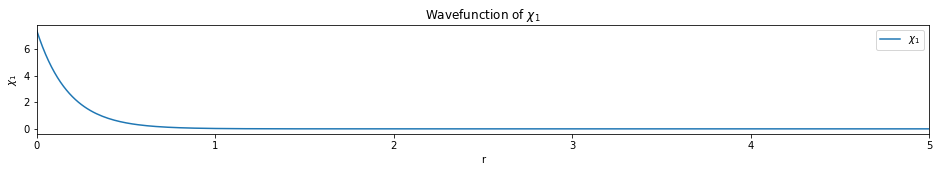

In [95]:
x = np.linspace(0, 5, 300)
y = f(x)
plt.figure(figsize=(16,2))
plt.plot(x, y, label='$\chi_{}$'.format(1))
plt.legend()
plt.xlim(0, x[-1])
plt.xlabel('r')
plt.ylabel('$\chi_1$')
plt.title('Wavefunction of $\chi_1$')
plt.show()

<font color=red>Code below is example solution</font>

In [75]:
def run_hf(bfs, Z):
    """
    Run restricted hartree fock for a single atom.

    INPUT:
        bfs: basis functions
        Z: nuclear charge of the atom
    """
    print('------------------------------', "Initialization", '------------------------------')
    print('-------------------------', "Ignore repulsion integral", '------------------------')
    N = Z  # num of electron = nuclear charege (since it's atom)
    start = time.time()

    # initialization
    H = H_matrix(bfs, Z)
    S = S_matrix(bfs)
    e, Co = secular_eqn(H, S)
    P = P_matrix(Co, N)
    Vnn = 0  # A single atom does not have nuclear repulsion
    hf_e = energy_tot(e, N, P, H, Vnn)

    stop = time.time()
    print_info(S, H, e, Co, P, hf_e, start, stop, verbose=verbose)
    print('-----------', "Caculating Electron Repulsion Integral (takes time)", '------------')
    R = R_matrix(bfs)
    delta_e = 1
    ITER = 0
    previous_e = hf_e

    densities = [] # [[d1, d2], [d1, d2], [d1, d2]]
    # plot 
    x = np.linspace(0, 5, 300)
    tmp_density = get_density(bfs, Co, x)
    densities.append(tmp_density)

    # Iterations
    while(delta_e > E_conv and ITER < MAXITER):
        print('------------------------------', "Iteration", ITER + 1, '------------------------------')
        start = time.time()

        # important scf steps
        G = G_matrix(P, R)
        F = H + G
        e, Co = secular_eqn(F, S)
        P = P_matrix(Co, N)
        hf_e = energy_tot(e, N, P, H, Vnn)

        delta_e = np.abs(hf_e - previous_e)
        previous_e = hf_e
        ITER += 1
        stop = time.time()
        print_info(S, H, e, Co, P, hf_e, start, stop, delta_e, verbose=verbose)

        # plot
        tmp_density = get_density(bfs, Co, x)
        densities.append(tmp_density)

    plot_density(densities, x)


    return hf_e

In [55]:
def get_density(bfs, Co, x):
    r = sp.Symbol('r')
    density = []
    
    # all orbitals
    for i in range(Co.shape[0]):
        tmp_orbital = 0
        # all basis functions
        for j, f in enumerate(bfs):
            tmp_orbital += Co[j][i] * bfs[j]
        tmp_d_function = tmp_orbital * tmp_orbital * r * r * 4 * np.pi
        tmp_f = sp.lambdify(r, tmp_d_function, "numpy")
        tmp_d = tmp_f(x)
        density.append(tmp_d)
    return density

In [71]:
def plot_density(densities, x):
    num_orbitals = len(densities[0])
    num_iterations = len(densities)

    for i in range(num_orbitals):
        plt.figure(figsize=(16,2))
        for j, d in enumerate(densities):
            if j == 0 or j == (num_iterations - 1):
                plt.plot(x, d[i], label='iteration {}'.format(j+1))
            else:
                plt.plot(x, d[i])
        plt.legend()
        plt.xlim(0, x[-1])
        plt.xlabel('r')
        plt.ylabel('$4 \pi r^2 |\phi_{}|^2$'.format(i+1))
        plt.title('charge density of $\phi_{}$'.format(i+1))
        plt.show()
    
    plt.figure(figsize=(16,2))
    for i, d in enumerate(densities[-1]):
        plt.plot(x, d, label='$\phi_{}$'.format(i+1))
    plt.legend()
    plt.xlim(0, x[-1])
    plt.xlabel('r')
    plt.ylabel('$4 \pi r^2 |\phi_i|^2$')
    plt.title('charge density of all orbitals $\phi_i$ (final iteration)')
    plt.show()

------------------------------ Initialization ------------------------------
------------------------- Ignore repulsion integral ------------------------
HF energy: -3.95924 (hartree) = -107.73486 (eV)
time used: 0.2 s
----------- Caculating Electron Repulsion Integral (takes time) ------------
time Repu: 2.7 s
------------------------------ Iteration 1 ------------------------------
HF energy: -2.78457 (hartree) = -75.77099 (eV)
dE       : 1.17e+00
time used: 0.0 s
------------------------------ Iteration 2 ------------------------------
HF energy: -2.85860 (hartree) = -77.78532 (eV)
dE       : 7.40e-02
time used: 0.0 s
------------------------------ Iteration 3 ------------------------------
HF energy: -2.86152 (hartree) = -77.86490 (eV)
dE       : 2.92e-03
time used: 0.0 s
------------------------------ Iteration 4 ------------------------------
HF energy: -2.86167 (hartree) = -77.86877 (eV)
dE       : 1.42e-04
time used: 0.0 s
------------------------------ Iteration 5 ------------

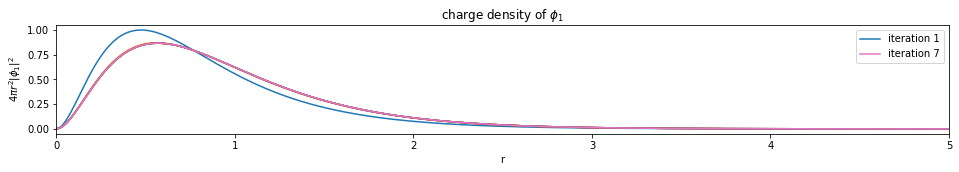

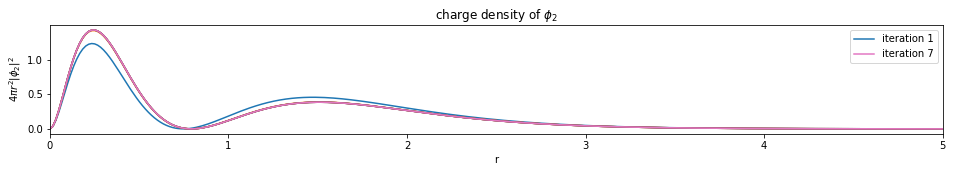

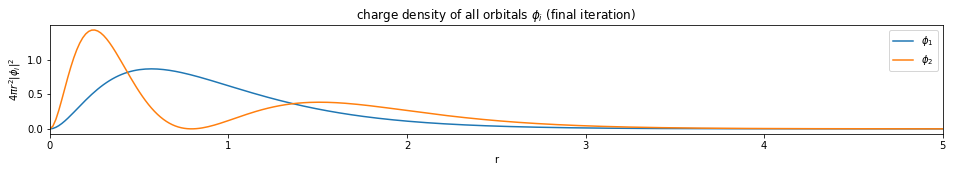

-------------------------------- PASSED ---------------------------------
cal: -2.8616726, ref: -2.8616726




In [73]:
test1()

------------------------------ Initialization ------------------------------
------------------------- Ignore repulsion integral ------------------------
HF energy: -19.51846 (hartree) = -531.11686 (eV)
time used: 0.7 s
----------- Caculating Electron Repulsion Integral (takes time) ------------
time Repu: 52.7 s
------------------------------ Iteration 1 ------------------------------
HF energy: -14.28744 (hartree) = -388.77544 (eV)
dE       : 5.23e+00
time used: 0.0 s
------------------------------ Iteration 2 ------------------------------
HF energy: -14.50425 (hartree) = -394.67518 (eV)
dE       : 2.17e-01
time used: 0.0 s
------------------------------ Iteration 3 ------------------------------
HF energy: -14.55105 (hartree) = -395.94867 (eV)
dE       : 4.68e-02
time used: 0.0 s
------------------------------ Iteration 4 ------------------------------
HF energy: -14.56616 (hartree) = -396.35976 (eV)
dE       : 1.51e-02
time used: 0.0 s
------------------------------ Iteration 5 --

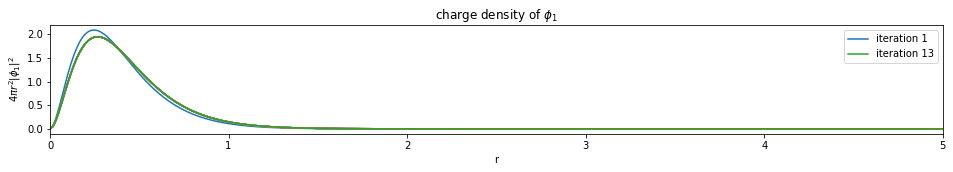

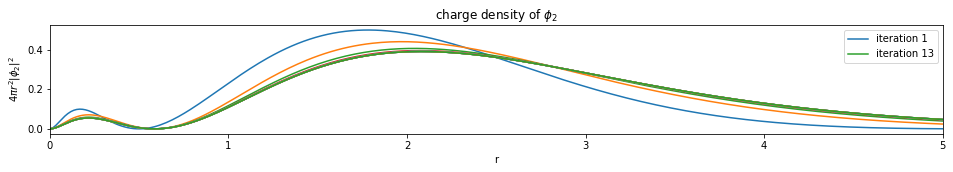

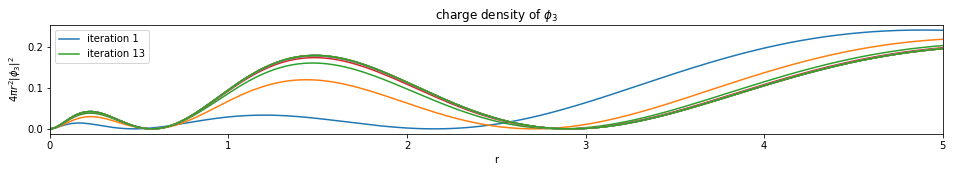

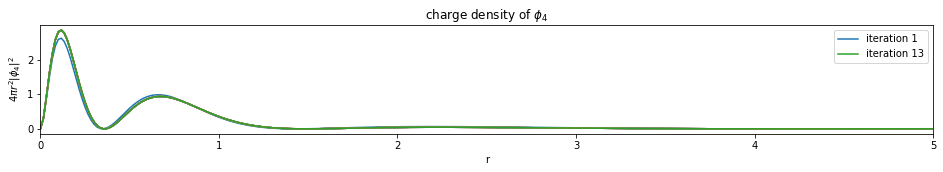

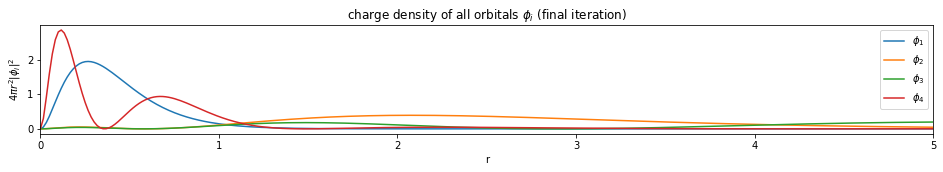

-------------------------------- PASSED ---------------------------------
cal: -14.5723687, ref: -14.5723690




In [74]:
test2()

### 12. Limitations
Limitations of this implementation:  
1. Because of the coordinate system (Spherical coordinate system), this implementation can only deal with atom.
1. Because angular part is not included in current STO function, only atoms which only have s orbital could be represented by STO.
1. For restricted hartree fock, could only run closed shell atom.
1. Integral calculated by sympy, which is slow but easy to understand.


### 13. Reference
[1] Levine, Quantum Chemistry, 7th Edition, chapter 14  
[2] Wikipedia
[Hartree–Fock method](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method#Hartree%E2%80%93Fock_algorithm), 
[Fock matrix](https://en.wikipedia.org/wiki/Fock_matrix), 
[Roothaan equations](https://en.wikipedia.org/wiki/Roothaan_equations), 
[Coulomb operator](https://en.wikipedia.org/wiki/Coulomb_operator), 
[Exchange operator](https://en.wikipedia.org/wiki/Exchange_operator)  
[3] Clementi, Enrico, and Carla Roetti. [Roothaan-Hartree-Fock atomic wavefunctions: Basis functions and their coefficients for ground and certain excited states of neutral and ionized atoms, Z≤ 54.](https://www.sciencedirect.com/science/article/pii/S0092640X74800161) Atomic data and nuclear data tables 14.3-4 (1974): 177-478.  
[4] Acosta C R. [Restricted closed shell Hartree Fock Roothaan matrix method applied to Helium atom using Mathematica[J].](https://files.eric.ed.gov/fulltext/EJ1051495.pdf) European Journal of Physics Education, 2017, 5(1): 1-14.  
[5] Jacob Martin, [Simple Quantum Chemistry: Hartree-Fock in Python](http://nznano.blogspot.com/2018/03/simple-quantum-chemistry-hartree-fock.html), 2018  
[6] Claire Vallance, [Calculating Orbital Energies and Expansion Coefficients](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Book%3A_Symmetry_(Vallance)/20%3A_Calculating_Orbital_Energies_and_Expansion_Coefficients), 2019